# Alpha lifetime

An script to compute alpha lifetime.

In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import numpy as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.reco. dst_functions as dstf

from icaro.core.kdst_functions import event_rate
from icaro.core.kdst_functions import profile_and_fit
from icaro.core.kdst_functions import time_from_timestamp
from icaro.core.kdst_functions import to_deltatime
from icaro.core.kdst_functions import lifetime_vs_t
from icaro.core.kdst_functions import save_lifetime

2017-05-24 17:27:50


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

# Configuration

In [4]:
run_number    = 4074
data_filename = "/Users/Gonzalo/github/NEXTdata/Alphas/dst_{}.root.h5".format(run_number)
text_filename = "/Users/Gonzalo/github/NEXTdata/Alphas/Lifetimes.txt"
run_comment   = ""

# Read data

In [5]:
full       = dstf.load_dst(data_filename, "DST", "Events")
t_begin    = np.min(full.time)
t_end      = np.max(full.time)
run_dt     = t_end - t_begin
full.time -= t_begin
fid        = full[full.R < 100] # michel sorel cuts
cath       = full[full.Z > 500]
bulk       = full[full.Z < 500]

print("# alphas              :", len(full))
print("# alphas at R < 100 mm:", len(fid ))
print("# alphas at Z > 500 µs:", len(cath))
print("# alphas at Z < 500 µs:", len(bulk))

full.head()

# alphas              : 18420
# alphas at R < 100 mm: 4990
# alphas at Z > 500 µs: 542
# alphas at Z < 500 µs: 17878


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,0.000,0,1,275.0,356.742310,1966.679146,216450.0,10.966000,2520.960938,...,654887.5,10,438.4375,438.4375,-45.182123,-138.062274,145.267394,-1.887070,7.489001,8.690514
1,2,0.175,0,1,350.0,254.454712,1558.020130,553100.0,6.887500,4405.873047,...,653462.5,9,100.3625,100.3625,164.532294,65.722908,177.173295,0.380035,7.174754,6.755964
2,3,0.282,0,1,325.0,248.678024,1510.688494,647975.0,4.177625,9481.593750,...,651512.5,7,3.5375,3.5375,70.593458,-124.938606,143.502932,-1.056491,5.786842,5.185477
3,5,0.451,0,1,300.0,288.811981,1675.163487,388750.0,9.750625,3250.141113,...,655112.5,9,266.3625,266.3625,105.818062,23.792601,108.459901,0.221166,7.573740,7.565556
4,6,0.563,0,1,300.0,318.397736,1796.729677,318200.0,8.946063,1177.326172,...,653512.5,5,335.3125,335.3125,-189.105319,-72.921724,202.678069,-2.773549,4.926804,6.792970


# Trigger rate

Average trigger rate: 4.74 evts/s


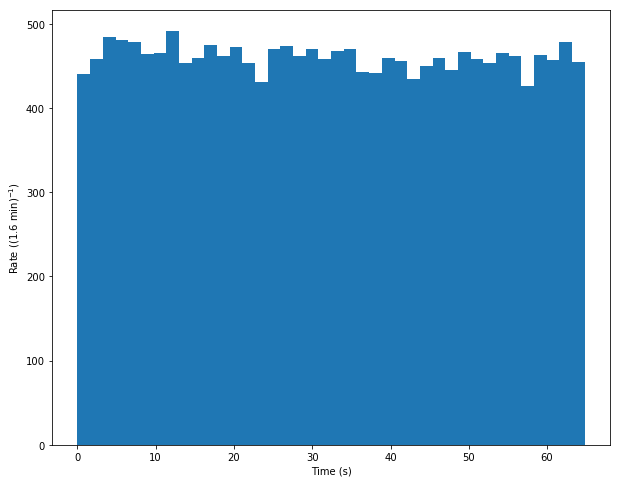

In [6]:
n, bins, _ = plt.hist(full.time/60, 40)
r = np.diff(bins)[0]
plt.xlabel("Time (s)")
plt.ylabel("Rate (({:.1f} min)$^{{-1}}$)".format(r))

rate = event_rate(full)
print("Average trigger rate: {:.2f} evts/s".format(rate))

# Energy distributions and correlations

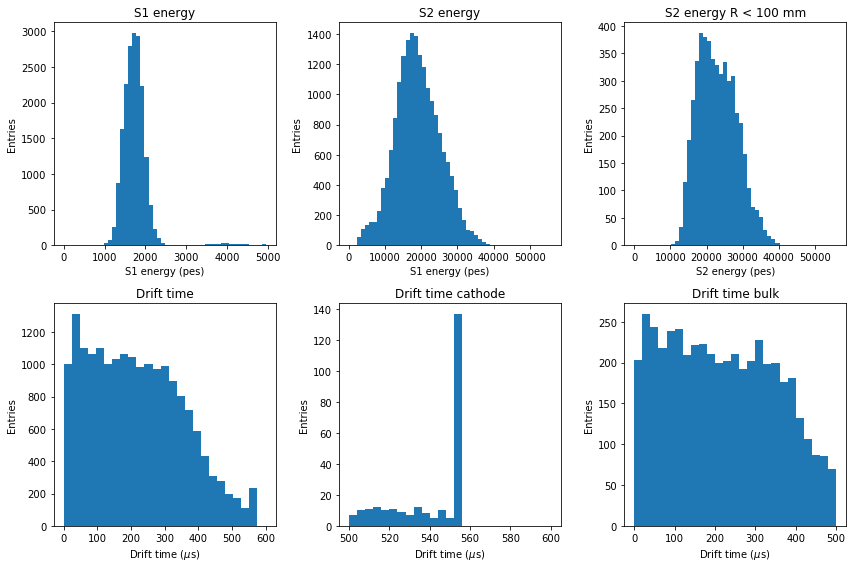

In [7]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.hist(full.S1e, 50, (0, np.max(full.S1e)))
plt.xlabel("S1 energy (pes)")
plt.ylabel("Entries")
plt.title('S1 energy')

plt.subplot(2, 3, 2)
plt.hist(full.S2e, 50, (0, np.max(full.S2e) * 1.2))
plt.xlabel("S1 energy (pes)")
plt.ylabel("Entries")
plt.title('S2 energy')

plt.subplot(2, 3, 3)
plt.hist(fid.S2e, 50, (0, np.max(full.S2e) * 1.2))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")
plt.title('S2 energy R < 100 mm')

plt.subplot(2, 3, 4)
plt.hist(full.Z, 25, (0, 600))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Entries")
plt.title('Drift time')

plt.subplot(2, 3, 5)
plt.hist(fid.Z, 25, (500, 600))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Entries")
plt.title('Drift time cathode')

plt.subplot(2, 3, 6)
plt.hist(fid.Z, 25, (0, 500))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Entries")
plt.title('Drift time bulk')

plt.tight_layout()

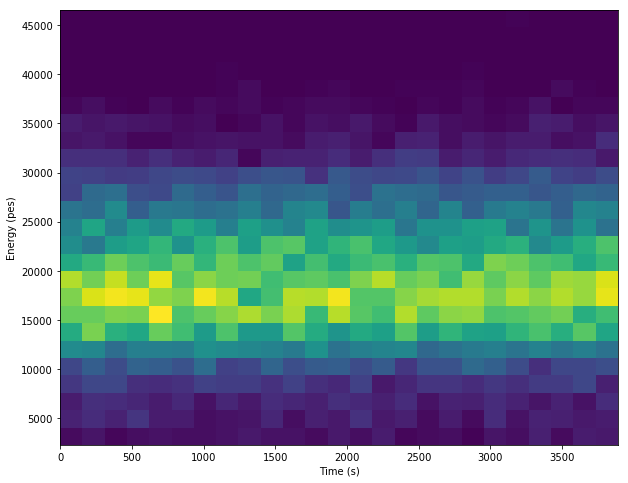

In [8]:
plt.hist2d(full.time, full.S2e, (25, 25))
plt.xlabel("Time (s)")
plt.ylabel("Energy (pes)");

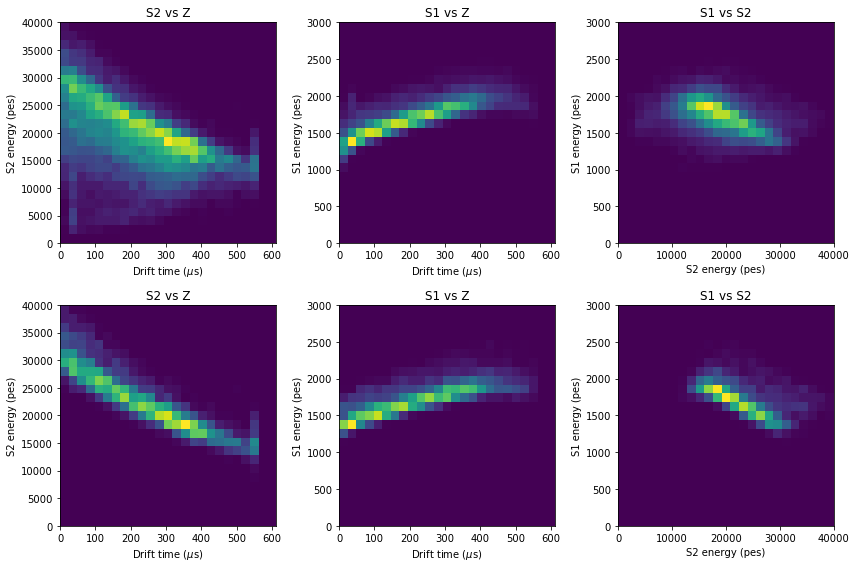

In [9]:
plt.figure(figsize=(12, 8))

zrange  = 0, 610
S2range = 0, 4e4
S1range = 0, 3e3

plt.subplot(2, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 energy (pes)")
plt.title('S2 vs Z')

plt.subplot(2, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S1 energy (pes)")
plt.title('S1 vs Z')

plt.subplot(2, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
plt.xlabel("S2 energy (pes)")
plt.ylabel("S1 energy (pes)")
plt.title('S1 vs S2')

plt.subplot(2, 3, 4)
plt.hist2d(fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 energy (pes)")
plt.title('S2 vs Z')

plt.subplot(2, 3, 5)
plt.hist2d(fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S1 energy (pes)")
plt.title('S1 vs Z')

plt.subplot(2, 3, 6)
plt.hist2d(fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
plt.xlabel("S2 energy (pes)")
plt.ylabel("S1 energy (pes)")
plt.title('S1 vs S2')

plt.tight_layout()


# Event distribution

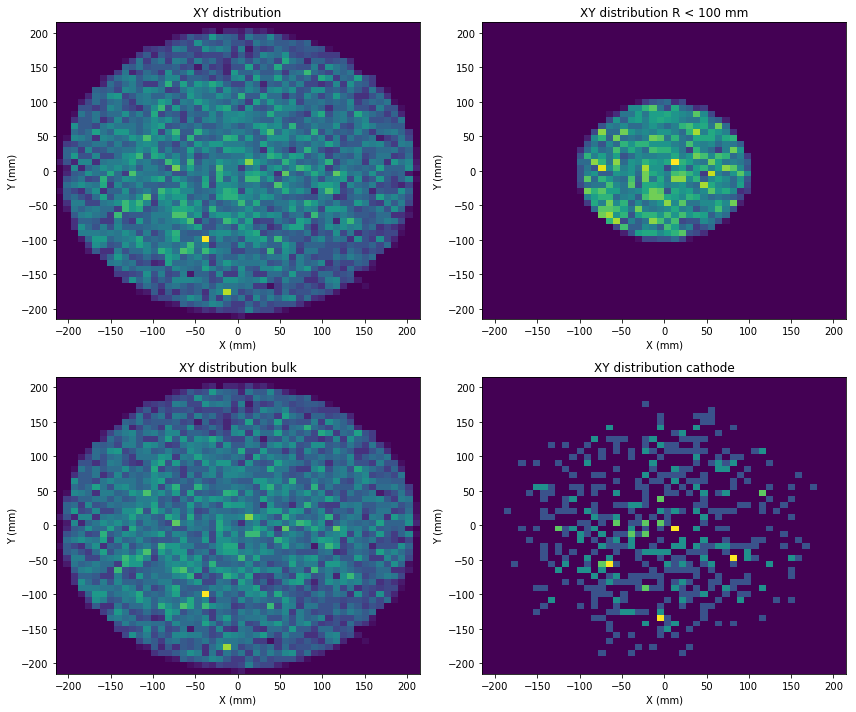

In [10]:
xrange  = -215, 215
yrange  = -215, 215
xyrange = xrange, yrange
xybins  = 50, 50
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.hist2d(full.X, full.Y, xybins, xyrange)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title('XY distribution')

plt.subplot(2, 2, 2)
plt.hist2d(fid.X, fid.Y, xybins, xyrange)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title('XY distribution R < 100 mm')

plt.subplot(2, 2, 3)
plt.hist2d(bulk.X, bulk.Y, xybins, xyrange)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title('XY distribution bulk')

plt.subplot(2, 2, 4)
plt.hist2d(cath.X, cath.Y, xybins, xyrange)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title('XY distribution cathode')

plt.tight_layout()

# Lifetime

Energy at Z=0: 32067 +- 149 pes
Lifetime     : 645.9 +- 7.6 µs 
Chi2 fit     : 3.78              


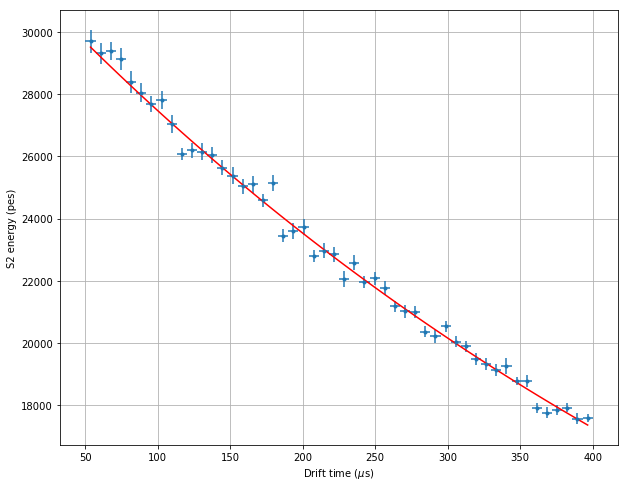

In [11]:
zrange =  50, 400
Erange = 1e3, 7e4
nbins  = 50
F, x, y, sy = profile_and_fit(fid.Z, fid.S2e, 
                              xrange = zrange, 
                              yrange = Erange, 
                              nbins  = nbins, 
                              fitpar = (50000,-300),
                              label  = ("Drift time ($\mu$s)", "S2 energy (pes)"))

print("Energy at Z=0: {:.0f} +- {:.0f} pes".format( F.values[0], F.errors[0]))
print("Lifetime     : {:.1f} +- {:.1f} µs ".format(-F.values[1], F.errors[1]))
print("Chi2 fit     : {:.2f}              ".format( F.chi2))
LT, LTu = -F.values[1], F.errors[1]

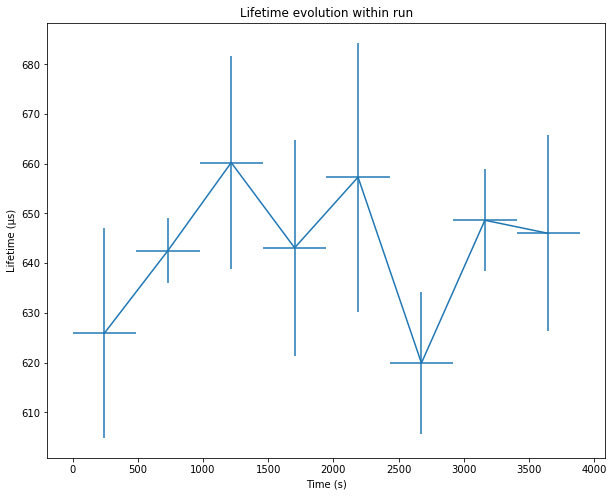

In [12]:
dst        = fid[coref.in_range(fid.Z, *zrange)]
timestamps = list(map(time_from_timestamp, dst.time))
lifetime_vs_t(dst, nslices=8, timestamps=timestamps)
plt.xlabel("Time (s)")
plt.ylabel("Lifetime (µs)")
plt.title("Lifetime evolution within run");

In [13]:
date_begin = time_from_timestamp(t_begin)
date_end   = time_from_timestamp(t_end  )
date_lapse = to_deltatime(t_begin, t_end, unit="s")

save_lifetime(text_filename,
              run_number,       LT,        LTu,
                 t_begin,    t_end,     run_dt,
              date_begin, date_end, date_lapse,
              comment="", delimiter=" ")

Overwrite value for run {} (y/n)? y
